In [1]:
import sys
from pathlib import Path

repo_root = Path.cwd().resolve().parents[1]  # …/collision_of_two_bodies
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))


In [2]:
from two_body.core import Config, set_global_seeds
from two_body.core.telemetry import setup_logger
from two_body.logic.controller import ContinuousOptimizationController
#from two_body.presentation.visualization import Visualizer
from two_body.simulation.rebound_adapter import ReboundSim
from two_body.presentation.triDTry import Visualizer
import numpy as np


In [3]:
def build_config(overrides=None):
    base = Config()
    if overrides:
        base = Config(**overrides)
    set_global_seeds(base.seed)
    return base

import logging

def run_case(case_name, overrides=None, verbose=True):
    cfg = build_config(overrides)
    base_logger = setup_logger()
    logger = logging.getLogger(f"case_{case_name.lower().replace(' ', '_')}")
    logger.setLevel(base_logger.level)
    if not logger.handlers:
        for h in base_logger.handlers:
            logger.addHandler(h)

    controller = ContinuousOptimizationController(cfg, logger=logger if verbose else None)
    result = controller.run()
    if verbose:
        logger.info("→ %s | mejor λ ≈ %.4f", case_name, -(result["best"]["lambda"] or float("nan")))
        print(result)
    return cfg, result


def visualize_best(cfg, result, horizon="short", show=False):
    best = result.get("best") or {}
    m1, m2 = best.get("m1"), best.get("m2")
    if m1 is None or m2 is None:
        print("Sin candidato válido para visualizar.")
        return

    masses = (m1, m2)
    r0 = tuple(cfg.r0[i] for i in range(len(masses)))
    v0 = tuple(cfg.v0[i] for i in range(len(masses)))

    sim_builder = ReboundSim(G=cfg.G, integrator=cfg.integrator)
    sim = sim_builder.setup_simulation(masses=masses, r0=r0, v0=v0)
    t_end = cfg.t_end_short if horizon == "short" else cfg.t_end_long
    traj = sim_builder.integrate(sim, t_end=t_end, dt=cfg.dt)
    
    xyz_tracks = [traj[:, idx, :3] for idx in range(traj.shape[1])]
    
    viz = Visualizer(headless=False)
    
    anim = viz.animate_3d(
        trajectories=xyz_tracks,
        title=f"Trayectorias 3D {best['m1']:.3f}, {best['m2']:.3f}",
        interval_ms=50, 
        total_frames=len(xyz_tracks[0]) 
    )
    
    return xyz_tracks, anim


In [4]:
cases = {
    "Caso A (baseline)": {},
    "Caso B (semilla distinta)": {"seed": 123},
    "Caso C (búsqueda acotada)": {
        "m1_bounds": (0.8, 1.2),
        "m2_bounds": (0.8, 1.2),
        "local_radius": 0.05,
    },
}


In [5]:
results = {}
for name, overrides in cases.items():
    cfg, result = run_case(name, overrides=overrides)
    results[name] = (cfg, result)


[2025-10-23 18:20:56,459] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-23 18:21:00,407] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-23 18:21:04,437] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-23 18:21:09,965] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-23 18:21:13,714] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-23 18:21:18,067] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-23 18:21:21,629] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-23 18:21:24,522] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-23 18:21:26,674] INFO - → Caso A (baseline) | mejor λ ≈ 4.9147


{'status': 'completed', 'best': {'m1': 7.113841649315993, 'm2': 5.534470215515473, 'lambda': -4.914682319549058, 'fitness': 4.914682319549058}, 'evals': 3600, 'epochs': 50}


[2025-10-23 18:21:32,209] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-23 18:21:37,393] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-23 18:21:40,441] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-23 18:21:43,296] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-23 18:21:48,329] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-23 18:21:51,628] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-23 18:21:54,146] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-23 18:21:56,075] INFO - → Caso B (semilla distinta) | mejor λ ≈ 4.9287


{'status': 'completed', 'best': {'m1': 6.775554036447786, 'm2': 5.8708892421020895, 'lambda': -4.928731673037113, 'fitness': 4.928731673037113}, 'evals': 3600, 'epochs': 50}


[2025-10-23 18:22:00,174] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-23 18:22:03,306] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-23 18:22:06,578] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-23 18:22:10,611] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-23 18:22:13,678] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-23 18:22:17,071] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-23 18:22:20,151] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-23 18:22:23,759] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-23 18:22:27,396] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-23 18:22:30,026] INFO - → Caso C (búsqueda acotada) | mejor λ ≈ 0.0002


{'status': 'completed', 'best': {'m1': 0.9037762329284473, 'm2': 1.0419031315895906, 'lambda': -0.0001918905801474256, 'fitness': 0.0001918905801474256}, 'evals': 3600, 'epochs': 50}


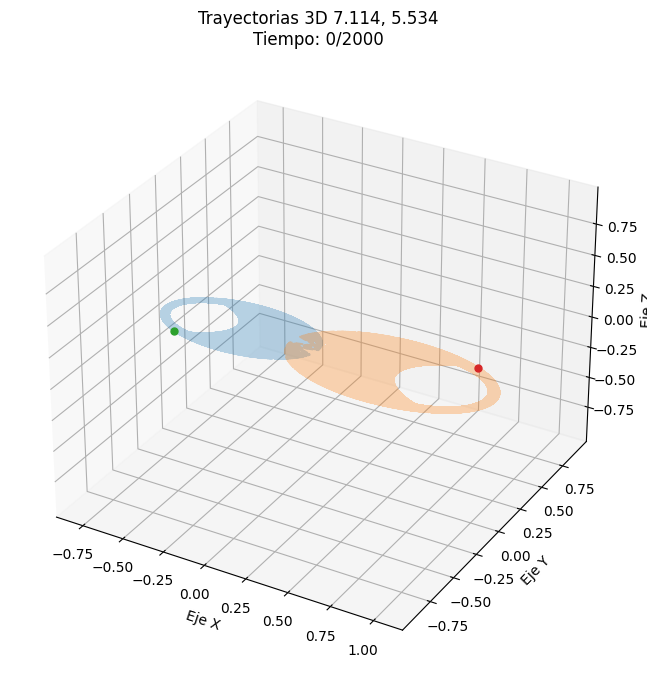

In [6]:

cfg_A, result_A = results["Caso A (baseline)"]

trayectorias_3d = visualize_best(cfg_A, result_A, horizon="long")

Visualizando Caso A (baseline)
Visualizando Caso B (semilla distinta)
Visualizando Caso C (búsqueda acotada)


c:\Users\52551\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


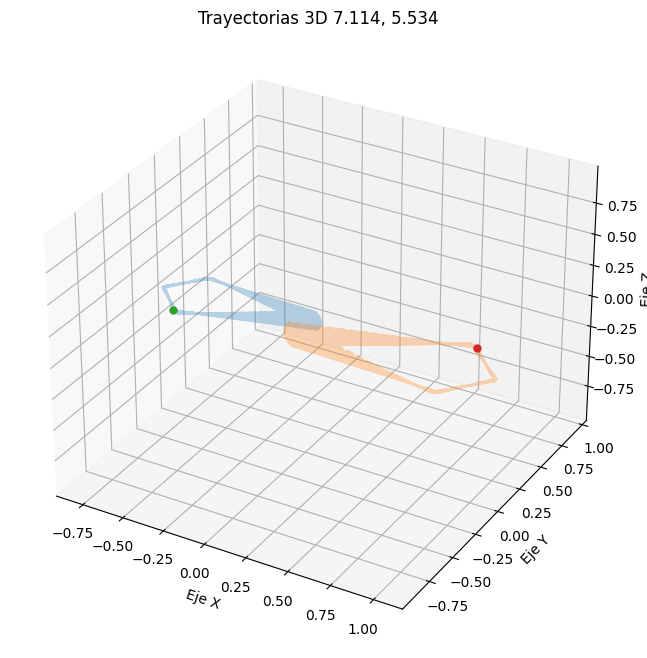

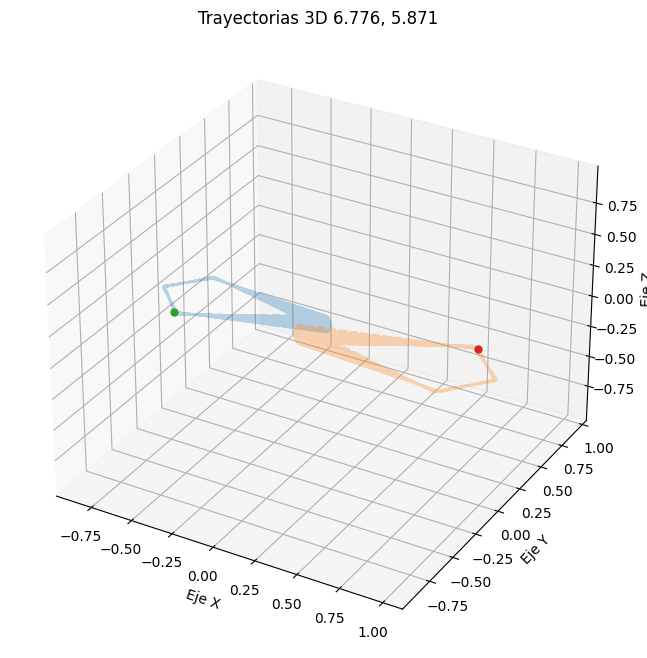

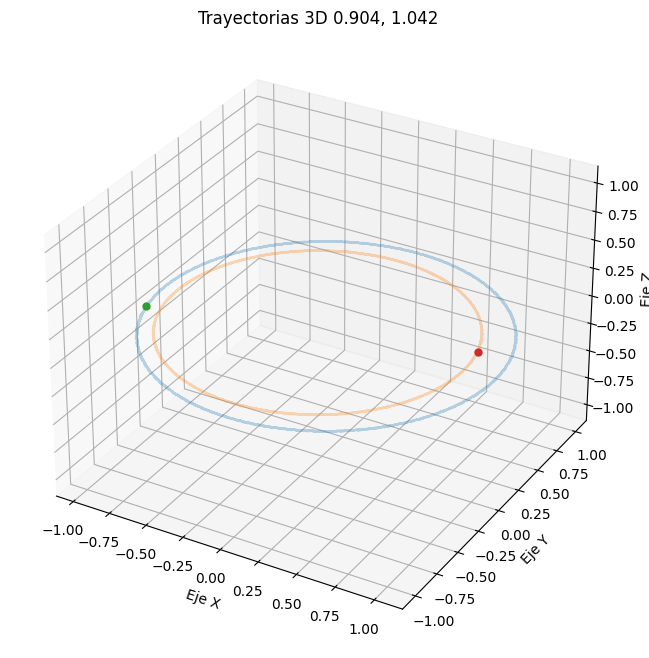

In [7]:
for name, (cfg, result) in results.items():
    print(f"Visualizando {name}")
    visualize_best(cfg, result, horizon="short", show=True)
